# Hackathon Oil&Gas: Data Warehouse

## Participants
- Cindy Ortega - cindy.or03@gmail.com
- Nicolás Bueno - nbuenoz@unal.edu.co
- Alejandro Uribe - jduriber@unal.edu.co

## Libraries

In [1]:
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
import pickle
from scipy.optimize import curve_fit
from calendar import monthrange

from utils import downloadData
from utils import dataProc
from utils import generateWeb
from utils import generateDB

## Downloading, Loading & Cleanning Data

In [2]:
#Using Pickle to save time during data loading
read = 0
if read:
    data = dataProc.dataProc()
    df = data.loadData()
    df_dict = data.cleanData(df)
    with open('df_dict.pickle', 'wb') as handle:
        pickle.dump(df_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('df_dict.pickle', 'rb') as handle:
    df_dict = pickle.load(handle)

## Missing step from cleanData

In [3]:
for i in df_dict.keys():
    df_dict[i]=df_dict[i].dropna(axis=1, thresh=5) #delete rows with just nan values
    df_dict[i].columns = df_dict[i].columns.str.replace(' ', '') #delete spaces in column names

## Functions definition to apply universal methods to any type of dataset

In [4]:
# Takes a dictionary of dataFrames and for each, groups the information by a given column
def grouping_data(df_dict, column):
    df = {}
    for i in df_dict.keys():
        df_temp = df_dict[i].groupby(column).sum() # Grouping as needed
        January =  df_temp.columns.get_loc('enero')# picking the group first month location
        if (i == '2014'): #Special treatment for missing months in the 2014 dataFrame
            df_temp['noviembre'] = 0.0
            df_temp['diciembre'] = 0.0
        df[i] = df_temp.loc[:, 'enero'::] # Assign clean table
    return df

# Gets the production data from a specified field in a dataFrame
def actual_data(campo, df):
    production = np.array([])
    dates = pd.date_range(f'2000-01-01', periods=0, freq='M')

    #Actual data
    for i in df.keys():
        if campo in df[i].index:
            dates = np.append(dates, pd.date_range(f'{i}-01-01', periods= df[i].loc[campo,:].size, freq='M'))
            production = np.append(production, df[i].loc[campo,:])
    
    # The "decline rate" concept is valid as long as production does not increase,
    # thus, maximum production rate should be located for decline calculations
    max_prod = np.max(production)
    a = np.where(production == max_prod)[0][0]
    t_data  = dates[a::]
    prod_data = production[a::]
    
    return production, dates, max_prod, t_data, prod_data

# Decline rate equation employing the Arps' equation for hyperbolic conditions
def rate_arps_hyp(times, Di):
    global production, b_arps, max_prod
    t = np.arange(times.size)
    q = max_prod/(1. + b_arps*Di*t)**(1/b_arps)
    return q

# Decline rate, D, in hyperbolic is not constant ( D = - 1/q * dq/dt )
# Initial decline rate is a constant parameter for history matching: Di
def decline_rate(times, Di):
    global b_arps
    t = np.arange(times.size)
    D = Di / (1+b_arps*Di*t)
    return D

## Arps equation for Hyperbolic rate:

## $ q(t) = q_i / (1.0 + b D_i t)^\frac{1}{b}$

# Decline rate validation
## In the following code, a criteria for grouping and a particular index can be choosen to depict its production data, oil decline history matching, and the initial and variable decline rate ($D$)

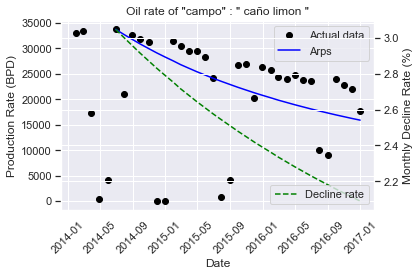

In [5]:

#Select hyperbolic exponent
b_arps = 0.5

#Select a grouping criterion and the desired index
criteria = 'campo'
index = "Caño limon"

#Grouping data
df_group = grouping_data(df_dict,criteria)
index = index.lower()

#Getting actual production data
production, dates, max_prod, t_data, prod_data = actual_data(index, df_group)

#Optimizing decline rate
Di_opt, Di_cov = curve_fit(rate_arps_hyp, t_data, prod_data)

# Plotting data and fit
fig = plt.figure()
ax1 = plt.axes()
ax1.set_xlabel('Date')
plt.xticks(rotation=45)
ax1.set_ylabel('Production Rate (BPD)')
ax1.set_title(f'Oil rate of "{criteria}" : " {index} "')

ax1.plot(dates, production,'o', color = 'black', label = 'Actual data')
ax1.plot(t_data, rate_arps_hyp(t_data, Di_opt),'-', color = 'blue', label = 'Arps')
ax1.legend(loc='upper right')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Monthly Decline Rate (%)')
ax2.plot(t_data, decline_rate(t_data, Di_opt)*100,'--', color = 'green', label = 'Decline rate')
ax2.legend(loc='lower right')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Downloading, Loading & Cleanning Blind Data

In [6]:
#Using Pickle to save time during data loading
read = 1
if read:
    data = dataProc.dataProc()
    df = data.loadBlindData()
    df_blind = data.cleanBlindData(df)
    with open('df_blind.pickle', 'wb') as handle:
        pickle.dump(df_blind, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('df_blind.pickle', 'rb') as handle:
    df_blind = pickle.load(handle)

Loading data blind test finished
Cleanning blind data
Cleaning blind data finsihed


## Question 1: Field "1F D2689F" Production rate in July, 2019

"campo" "1f-d2689f" in "julio - 2019" produced 4766.241346484784 barrels per day


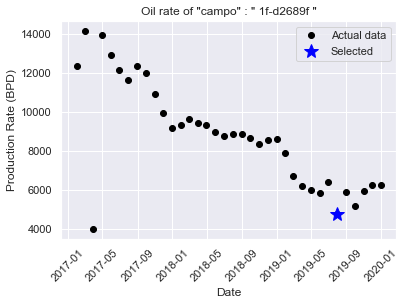

In [7]:
# Question 1 for blind test

#Select a grouping criterion and the desired index
criteria = 'campo'
index = '1F D2689F'
year = '2019'
month = 'julio'

#Grouping data
df_group_blind = grouping_data(df_blind,criteria)
index = index.lower().replace(" ","-")

# Getting the desired value to be reported
report = df_group_blind[year].loc[index,month]

# Printing the answer in the terminal
print(f'"{criteria}" "{index}" in "{month} - {year}" produced {report} barrels per day')

# Getting actual production data and locating of the desired value
production, dates, max_prod, t_data, prod_data = actual_data(index, df_group_blind)
where = np.where(production == report)[0][0]

# Plotting data 
fig = plt.figure()
ax1 = plt.axes()
ax1.set_xlabel('Date')
plt.xticks(rotation=45)
ax1.set_ylabel('Production Rate (BPD)')
ax1.set_title(f'Oil rate of "{criteria}" : " {index} "')
ax1.plot(dates, production,'o', color = 'black', label = 'Actual data')
ax1.plot(dates[where], production[where],'*', color = 'blue', label = 'Selected',markersize=15)
ax1.legend(loc='upper right')
plt.show()

## Question 2: Total Production of Company "2FE52430" in February, 2019  

"operadora" "2fe52430" in "febrero - 2019" produced 208662.17260608985 barrels


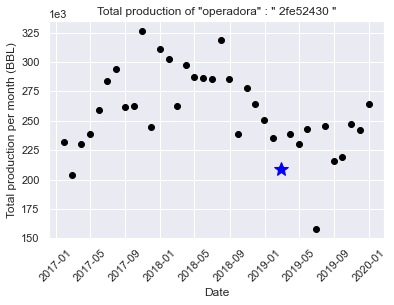

In [8]:
#Select a grouping criterion and the desired index
criteria = 'operadora'
df_group_blind = grouping_data(df_blind,criteria)
index = '2FE52430'
year = '2019'
month = 'febrero'

# Grouping data
index = index.lower().replace(" ","-")

# Getting the desired value to be reported
report = df_group_blind[year].loc[index,month] *  monthrange(int(year), 2)[1]

# Printing the answer in the terminal
print(f'"{criteria}" "{index}" in "{month} - {year}" produced {report} barrels')

#Getting actual production data
production, dates, max_prod, t_data, prod_data = actual_data(index, df_group_blind)

#Calculating the total production per month and locating of the desired value
dates_month = pd.DatetimeIndex(dates).month
days_per_month = np.array([monthrange(int(year), i)[1] for i in dates_month])
total_production = production*days_per_month
where = np.where(total_production == report)[0][0]

# Plotting data 
fig = plt.figure()
ax1 = plt.axes()
ax1.set_xlabel('Date')
plt.xticks(rotation=45)
ax1.set_ylabel('Total production per month (BBL)')
ax1.set_title(f'Total production of "{criteria}" : " {index} "')
ax1.ticklabel_format(axis='y',style='sci',scilimits=(3,3))
ax1.plot(dates, total_production,'o', color = 'black', label = 'Actual data')
ax1.plot(dates[where], total_production[where],'*', color = 'blue', label = 'Actual data',markersize=15)
plt.show()

## Question 3: Total production 

Total production (barrels) in 2018 by criteria: departamento

[ 3004801.89263314 18970777.53414348  3833958.25357653]


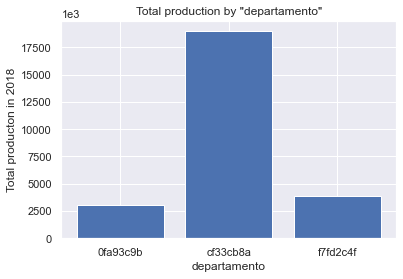

In [9]:
# Question 3 for blind test

#Select a grouping criterion and the desired index
criteria = 'departamento'
index = '2FE52430'
year = '2018'

# Grouping data
df_group_blind = grouping_data(df_blind,criteria)
index = index.lower().replace(" ","-")

# Calculating the days per month in a particular year
days_per_month = np.array([monthrange(int(year), i)[1] for i in np.arange(1,13)])

# Getting the desired value to be reported: dot product bewteen rates and days per month gives the total production in a year
report = np.dot(df_group_blind[year].iloc[:, :], days_per_month)

# Printing the answer in the terminal
print(f'Total production (barrels) in 2018 by criteria: {criteria}\n')
print(report)

# Plotting data
fig = plt.figure()
ax1 = plt.axes()
ax1.bar(df_group_blind[year].index, report)
ax1.set_xlabel(criteria)
ax1.set_ylabel(f'Total producton in {year}')
ax1.set_title(f'Total production by "{criteria}"')
ax1.ticklabel_format(axis='y', style='sci',scilimits=(3,3))

## Question 4: Departments with the highest variation in per-field annual average production

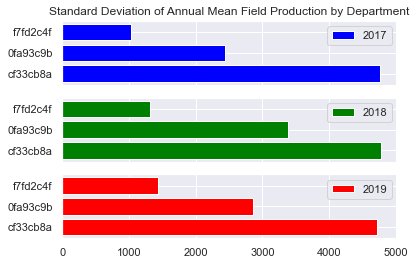

In [10]:
df_4 = {}

# The criteria compares between departments
criteria = 'departamento'
for i in df_blind.keys():
    # Getting locations of first and last months
    January =  df_blind[i].columns.get_loc('enero')# picking the first month location
    December = df_blind[i].columns.get_loc('diciembre')# picking the last month location

    # Calculating the annual mean production for each field in all years
    df_blind[i]['Anual_Mean'] = np.mean(df_blind[i].iloc[:,January:December+1], axis=1)

    # Grouping by department using the standard deviation as aggregate
    df_4[i] = df_blind[i].groupby([criteria])['Anual_Mean'].aggregate('std')
    
    # Dropping nan (departments with only one field) and sorting arrays decreasingly
    df_4[i].dropna(inplace=True)
    df_4[i].sort_values(ascending=False, inplace=True)

# Plotting data
fig, ax = plt.subplots(3, sharex=True)
ax[0].barh(df_4['2017'][0:3].index, df_4['2017'][0:3], align='center', color = 'blue', label='2017')
ax[1].barh(df_4['2018'][0:3].index, df_4['2018'][0:3], align='center', color = 'green', label='2018')
ax[2].barh(df_4['2019'][0:3].index, df_4['2019'][0:3], align='center', color = 'red', label='2019')

ax[0].set_title('Standard Deviation of Annual Mean Field Production by Department');

ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')
ax[2].legend(loc='upper right')
plt.show()

## Question 5: Average Monthly Decline Rate for Field "51CBB05D" using Arps with $b=0.5$

## Remember that decline rate defines as: 
## $D = f(q)= -\frac{1}{q} \frac{dq}{dt}$
where 
## $D = f (q_0) = D_i$

## D_i is a constant parameter that can be adjusted to fit the production data.
## However, as $D$ depends on $q$, the average decline rate $D$ can be different from $D_i$

# Both, $D$ and $D_i$ are reported here

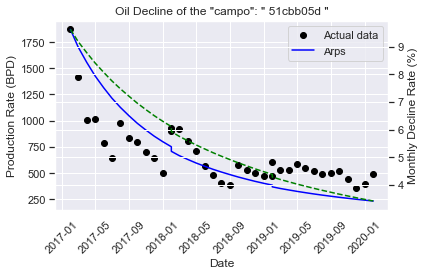

Initial Decline Rate (%): [9.63930728]
Total Average of Monthly Decline is 5.505507529523875 % for "campo": "51cbb05d"


In [12]:
#Selecting hyperbolic exponent
b_arps = 0.5

#Select a grouping criterion and the desired index
criteria = 'campo'
index = "51CBB05D"

#Grouping data
df_group_blind = grouping_data(df_blind,criteria)
index = index.lower().replace(" ","-")

#Getting actual production data
production, dates, max_prod, t_data, prod_data = actual_data(index, df_group_blind)

#Sorting production as dates are not in order 
i = np.argsort(dates)
i2 = np.argsort(t_data)

#Optimizing decline rate
Di_opt, Di_cov = curve_fit(rate_arps_hyp, t_data[i2], prod_data[i2])

# Plotting data and fit
fig = plt.figure()
ax1 = plt.axes()

ax1.set_xlabel('Date')
plt.xticks(rotation=45)
ax1.set_ylabel('Production Rate (BPD)')
ax1.set_title(f'Oil Decline of the "{criteria}": " {index} "')
ax1.plot(dates[i], production[i],'o', color = 'black', label = 'Actual data')
ax1.plot(t_data[i2], rate_arps_hyp(t_data[i2], Di_opt),'-', color = 'blue', label = 'Arps')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax2.set_ylabel('Monthly Decline Rate (%)')
ax2.plot(t_data[i2], decline_rate(t_data[i2], Di_opt)*100,'--', color = 'green', label = 'Decline rate')
ax1.legend()
plt.show()

# Printing the answer in the terminal
print(f'Initial Decline Rate (%): {Di_opt*100}')
print(f'Total Average of Monthly Decline is {np.mean(decline_rate(t_data[i2], Di_opt)*100)} % for "{criteria}": "{index}"')


In [14]:
print(dates[i])

['2017-01-31T00:00:00.000000000' '2017-02-28T00:00:00.000000000'
 '2017-03-31T00:00:00.000000000' '2017-04-30T00:00:00.000000000'
 '2017-05-31T00:00:00.000000000' '2017-06-30T00:00:00.000000000'
 '2017-07-31T00:00:00.000000000' '2017-08-31T00:00:00.000000000'
 '2017-09-30T00:00:00.000000000' '2017-10-31T00:00:00.000000000'
 '2017-11-30T00:00:00.000000000' '2017-12-31T00:00:00.000000000'
 '2018-01-31T00:00:00.000000000' '2018-01-31T00:00:00.000000000'
 '2018-02-28T00:00:00.000000000' '2018-03-31T00:00:00.000000000'
 '2018-04-30T00:00:00.000000000' '2018-05-31T00:00:00.000000000'
 '2018-06-30T00:00:00.000000000' '2018-07-31T00:00:00.000000000'
 '2018-08-31T00:00:00.000000000' '2018-09-30T00:00:00.000000000'
 '2018-10-31T00:00:00.000000000' '2018-11-30T00:00:00.000000000'
 '2018-12-31T00:00:00.000000000' '2019-01-31T00:00:00.000000000'
 '2019-01-31T00:00:00.000000000' '2019-02-28T00:00:00.000000000'
 '2019-03-31T00:00:00.000000000' '2019-04-30T00:00:00.000000000'
 '2019-05-31T00:00:00.000